### Problem Statement
- The given problem is to classify between text image and no text image.
- We will leverage the magic of Deep Learning to complete this task.

###  Data Description
- We have 5,875 RGB images of size 64x64 (train).
- We have 98 RGB test images.

### Goal
- The goal is to create deep learning models to predict the class(text and no text).
- Create a JSON file with prediction of test images.

### Business Constraint
- Latancy is not an issue considering end user requirement.

## Importing Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
for device in tf.config.get_visible_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.callbacks import *
import cv2
import json
import os
from skimage.io import *
from skimage.transform import resize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
tf.config.experimental_run_functions_eagerly(True)

GPU 0: NVIDIA GeForce GTX 1050 Ti (UUID: GPU-7a2eb0f1-f29d-dc70-85d6-ac9df8686b75)
GPU 1: NVIDIA GeForce GTX 1660 SUPER (UUID: GPU-68b71a8f-1517-bdfc-f8c4-0f0913519f9a)
GPU 2: NVIDIA GeForce GTX 1050 Ti (UUID: GPU-9c4b5a58-a4f8-cda7-897f-f77a19360388)


### Data Directories and Image dimensions

In [2]:
train_dir = 'training/'
img_h, img_w = 64, 64
dim = (img_h, img_w, 3)
bs = 64

## Loading Images

In [41]:
train_gen = ImageDataGenerator(rescale = 1/255, validation_split = 0.20)#, vertical_flip = True, horizontal_flip = True)

train = train_gen.flow_from_directory(train_dir, class_mode = 'binary', target_size = (img_h, img_w), batch_size = bs,
                                      subset = 'training')

val = train_gen.flow_from_directory(train_dir, class_mode = 'binary', target_size = (img_h, img_w), batch_size = bs,
                                  subset = 'validation')

Found 4700 images belonging to 2 classes.
Found 1175 images belonging to 2 classes.


## Sample Output of Images

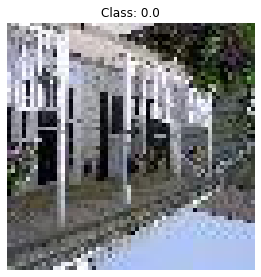

In [43]:
samp_x, samp_y = next(train)
n = np.random.randint(0, len(samp_x), 1)[0]
imshow(samp_x[n])
plt.axis('off')
plt.title('Class: '+str(samp_y[n]))
plt.show()

## Model Architecture

In [116]:
inp = Input((dim), name = 'Input')

conv = Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu' , dilation_rate = 1,
              name = 'Conv_1')(inp)
conv = Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu', dilation_rate = 2,
              name = 'Conv_2')(conv)
pool = MaxPool2D(2, name = 'Pool_1')(conv)


conv = Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu', dilation_rate = 3,
              name = 'Conv_3')(pool)
conv = Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu', dilation_rate = 4,
              name = 'Conv_4')(conv)
pool = MaxPool2D(2, name = 'Pool_2')(conv)


drop = Dropout(0.9, name = 'Dropout')(pool)
flat = Flatten(name = 'Flat')(drop)

dense = Dense(units = 32, activation = 'relu', name = 'Dense_1')(flat)

dense = Dense(units = 16, activation = 'relu', name = 'Dense_2')(dense)

dense = Dense(units = 1, activation = 'sigmoid', name = 'Output')(dense)

model = Model(inp, dense)
model.compile('adam', 'binary_crossentropy', 'accuracy')
model.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 64, 64, 3)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 64, 64, 64)        832       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 64, 64, 64)        16448     
_________________________________________________________________
Pool_1 (MaxPooling2D)        (None, 32, 32, 64)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 32, 32, 32)        8224      
_________________________________________________________________
Conv_4 (Conv2D)              (None, 32, 32, 32)        4128      
_________________________________________________________________
Pool_2 (MaxPooling2D)        (None, 16, 16, 32)        0  

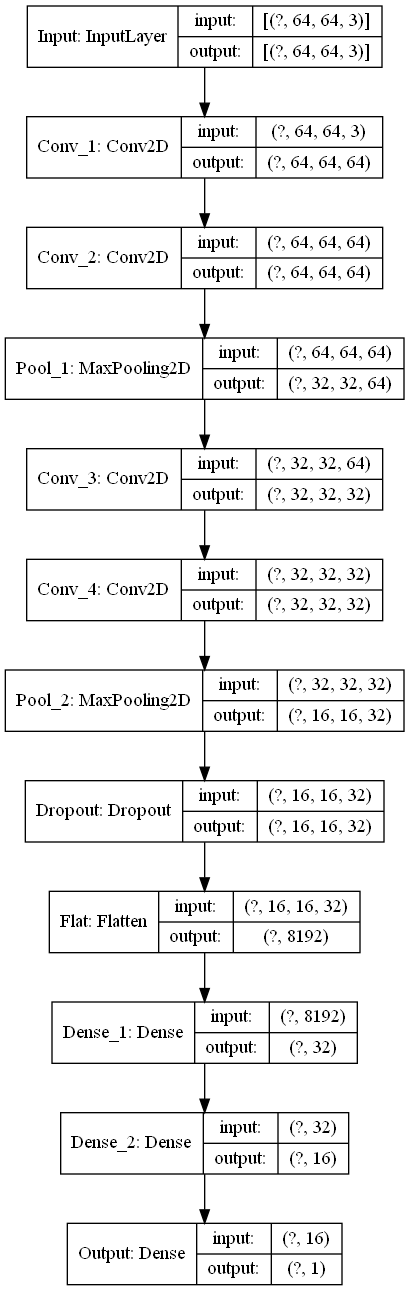

In [117]:
tf.keras.utils.plot_model(model, show_shapes = True)

## Training Model

In [118]:
check = ModelCheckpoint('model.h5', save_best_only = True)
early = EarlyStopping(patience = 2, restore_best_weights = True)
model.fit(train, epochs = 100, validation_data = (val), steps_per_epoch = train.n//bs,
              callbacks = [early, check], validation_steps = val.n//bs)

Epoch 1/100
73/73 [==============================] - 5s 66ms/step - loss: 0.5598 - accuracy: 0.7552 - val_loss: 0.5368 - val_accuracy: 0.7569
Epoch 2/100
73/73 [==============================] - 5s 64ms/step - loss: 0.4301 - accuracy: 0.7983 - val_loss: 0.3373 - val_accuracy: 0.8472
Epoch 3/100
73/73 [==============================] - 5s 64ms/step - loss: 0.3021 - accuracy: 0.8829 - val_loss: 0.2432 - val_accuracy: 0.9210
Epoch 4/100
73/73 [==============================] - 5s 64ms/step - loss: 0.2573 - accuracy: 0.9053 - val_loss: 0.2177 - val_accuracy: 0.9089
Epoch 5/100
73/73 [==============================] - 5s 65ms/step - loss: 0.2042 - accuracy: 0.9247 - val_loss: 0.1952 - val_accuracy: 0.9262
Epoch 6/100
73/73 [==============================] - 5s 64ms/step - loss: 0.1856 - accuracy: 0.9340 - val_loss: 0.2535 - val_accuracy: 0.8993
Epoch 7/100
73/73 [==============================] - 5s 64ms/step - loss: 0.1663 - accuracy: 0.9383 - val_loss: 0.1599 - val_accuracy: 0.9384
Epoch 

## Model Evaluating and Visualization

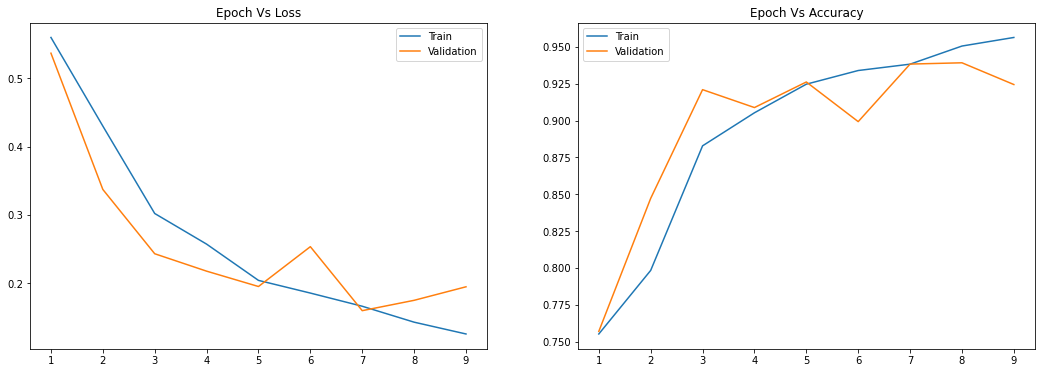

In [119]:
fig, ax = plt.subplots(1, 2)

train_losses, val_losses = model.history.history['loss'], model.history.history['val_loss']
train_acc, val_acc = model.history.history['accuracy'], model.history.history['val_accuracy']
ax[0].plot(list(range(1, len(train_losses)+1)), train_losses, label = 'Train')
ax[0].plot(list(range(1, len(train_losses)+1)), val_losses, label = 'Validation')
ax[0].legend()
ax[0].set_title('Epoch Vs Loss')

ax[1].plot(list(range(1, len(train_losses)+1)), train_acc, label = 'Train')
ax[1].plot(list(range(1, len(train_losses)+1)), val_acc, label = 'Validation')
ax[1].legend()
ax[1].set_title('Epoch Vs Accuracy')
fig.set_figheight(6)
fig.set_figwidth(18)
plt.show()

In [120]:
model.evaluate(val)

19/19 [==============================] - 1s 36ms/step - loss: 0.1617 - accuracy: 0.9370


[0.16165709495544434, 0.9370212554931641]

In [183]:
result = {}
files = os.listdir('test')
for file in files:
    path = os.path.join('test', file)
    img = imread(path)/255
    img = np.expand_dims(img, 0)
    pred = model.predict(img)[0]
    result[file] = pred
pred = np.vstack(pred)
pred = (pred1 > 0.6).astype("int32")

In [188]:
result = {}
files = os.listdir('test')
for file in files:
    path = os.path.join('test', file)
    img = imread(path)/255
    img = np.expand_dims(img, 0)
    pred = (model.predict(img) > 0.6).astype("int32")[0][0]
    result[file] = pred
json.dump(d, open('result.json', 'w'))